# Visualize Predetermined Acquisitions
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        try:
            keys = tuple(obj.keys())
            if keys in __namedtuples:
                nt = __namedtuples[keys]
            else:
                nt = namedtuple(type_name, keys)
                __namedtuples[keys] = nt
            return nt(*(to_namedtuple(v, "type_" + k) for k, v in obj.items()))
        except ValueError:
            return {k: to_namedtuple(v, f"{type_name}_{i}") for i, (k, v) in enumerate(obj.items())}
    if isinstance(obj, list):
        item_type_name = "element_" + type_name 
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = "element_" + type_name 
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = "element_" + type_name 
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
import torch

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan, torch])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
#results = load_laaos_files("./results/cifar10_coreset_pig_bad_golden")
#esults = load_laaos_files("./results/cifar10_coreset_pig_golden_workshop_pool_set")
results = load_laaos_files("./results/predetermined_acquisitions_mnist")

In [ ]:
original_result = to_namedtuple(torch.load("extracted_scores_results.tpickle"), "Results")

In [ ]:
get_any(results).config

_typeConfig(seed=6, experiment_data_config=_typeExperimentDataConfig(id_dataset_name='MNIST', id_repetitions=1, initial_training_set_size=20, validation_set_size=4096, validation_split_random_state=0, evaluation_set_size=0, add_dataset_noise=False, ood_dataset_config=None), acquisition_size=5, max_training_epochs=120, num_pool_samples=100, num_validation_samples=20, num_training_samples=1, device='cuda', acquisition_function='batchbald_redux.acquisition_functions.BALD', train_eval_model='batchbald_redux.train_eval_model.TrainSelfDistillationEvalModel', model_trainer_factory='batchbald_redux.models.MnistModelTrainer', ensemble_size=2, temperature=0.0, epig_bootstrap_type='BootstrapType.NO_BOOTSTRAP', epig_bootstrap_factor=1.0, epig_dtype=torch.float64, disable_training_augmentations=False, cache_explicit_eval_model=False)

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,3,1643332845
1,0,1643316914
2,0,1642959158
3,1,1642972194
4,4,1643332844
5,2,1642985392
6,4,1643012539
7,1,1643329836
8,1,1642972581
9,3,1642996659


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

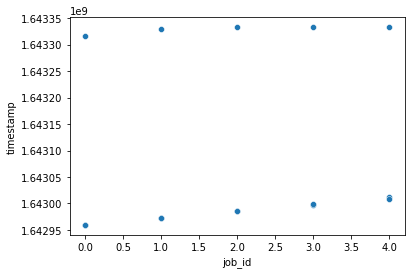

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(5, 15)

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue
        
    initial_training_set_size = 120 if "_120" in file else 70 if "_70" in file else 20
    print(initial_training_set_size)

    # It is 1, ignore config value!
    acquisition_size = 1
    
    acquisition_function = result.config.acquisition_function
    if acquisition_function.startswith("batchbald_redux.acquisition_functions."):
        acquisition_function=acquisition_function[len("batchbald_redux.acquisition_functions.") :]
    elif acquisition_function.startswith("batchbald_redux.baseline_acquisition_functions."):
        acquisition_function=acquisition_function[len("batchbald_redux.baseline_acquisition_functions.") :]
        
    num_pool_samples = result.config.num_pool_samples
    
    seed = result.config.seed

    #initial_set_size = len(result.initial_training_set_indices)

    for i, step in enumerate(result.active_learning_steps):
        if not hasattr(step, "evaluation_metrics"):
            break
        training_set_size = initial_training_set_size + i * acquisition_size
        if training_set_size > 220:
            break
            
        accuracy = step.evaluation_metrics.accuracy
        nll = step.evaluation_metrics.crossentropy

        experiment_data.append(
            dict(
                result_type=f"Predetermined (from {initial_training_set_size})",
                acquisition_function=acquisition_function,
                acquisition_size=acquisition_size,
                num_pool_samples=num_pool_samples,
                training_set_size=training_set_size,
                accuracy=accuracy,
                nll=nll,
                seed=seed,
            )
        )

70
70
120
20
70
20
120
70
120
20
70
20
20
120
120


In [ ]:
# Add the original trajectory!

# It is 1, ignore config value!
acquisition_size = 1

acquisition_function = "BALD"        
num_pool_samples = 100

seed = -1

initial_set_size = 20

for i, step in enumerate(original_result.active_learning_steps):
    if not hasattr(step, "evaluation_metrics"):
        break
    training_set_size = 20 + i * acquisition_size
    accuracy = step.evaluation_metrics.accuracy
    nll = step.evaluation_metrics.crossentropy

    experiment_data.append(
        dict(
            result_type="BALD",
            acquisition_function=acquisition_function,
            acquisition_size=acquisition_size,
            num_pool_samples=num_pool_samples,
            training_set_size=training_set_size,
            accuracy=accuracy,
            nll=nll,
            seed=seed,
        )
    )

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df.to_csv("BALD_predetermined_acquisitions.csv.xz", index=False)

In [ ]:
#df.to_pickle("plots_data/cifar10_coreset_pig_golden_workshop_pool_set.pkl")
df["cummaxacc"] = df.groupby(["seed", "result_type"])["accuracy"].cummax()

In [ ]:
df

,result_type,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,nll,seed,cummaxacc
0,Predetermined (from 70),BALD,1,100,70,0.8620,0.468021,6,0.8620
1,Predetermined (from 70),BALD,1,100,71,0.8791,0.428248,6,0.8791
2,Predetermined (from 70),BALD,1,100,72,0.8801,0.437523,6,0.8801
3,Predetermined (from 70),BALD,1,100,73,0.8711,0.469253,6,0.8801
4,Predetermined (from 70),BALD,1,100,74,0.8702,0.466848,6,0.8801
...,...,...,...,...,...,...,...,...,...
2491,BALD,BALD,1,100,246,0.9598,tensor(0.1952),-1,0.9644
2492,BALD,BALD,1,100,247,0.9631,tensor(0.1817),-1,0.9644
2493,BALD,BALD,1,100,248,0.9599,tensor(0.2025),-1,0.9644
2494,BALD,BALD,1,100,249,0.9590,tensor(0.2420),-1,0.9644


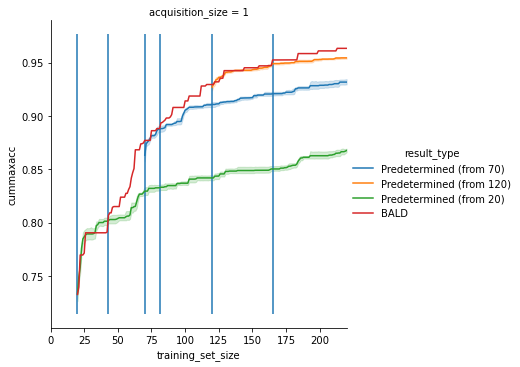

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="cummaxacc",
    col="acquisition_size",
    hue="result_type",
    #data=df[df.acquisition_function != "CoreSetPIGBALD"],
    data=df,
    kind="line",
    height=5,
    alpha=1
)

yminmax=grd.ax.get_ylim()
grd.ax.vlines([20, 43, 70, 81, 120, 165], *yminmax)
grd.ax.set_xlim(0, 220)

grd.fig.patch.set_alpha(1)

In [ ]:
dff = df.groupby(["result_type", "training_set_size"])["cummaxacc"].mean()

In [ ]:
dff= dff.reset_index()

In [ ]:
dff[dff.training_set_size.isin(list(range(76,84)))]

,result_type,training_set_size,cummaxacc
56,BALD,76,0.88630
57,BALD,77,0.88630
58,BALD,78,0.88630
59,BALD,79,0.88830
60,BALD,80,0.88830
61,BALD,81,0.88830
62,BALD,82,0.89370
63,BALD,83,0.89400
388,Predetermined (from 20),76,0.83224
389,Predetermined (from 20),77,0.83224


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
     # "training_set_size", "cummaxacc"]][(35 <= df.training_set_size) & (df.training_set_size <= 50)]

result_type               training_set_size
BALD                      20                   0.73280
                          21                   0.73980
                          22                   0.76980
                          23                   0.76980
                          24                   0.76980
                          25                   0.77160
                          26                   0.79060
                          27                   0.79060
                          28                   0.79060
                          29                   0.79060
                          30                   0.79060
                          31                   0.79060
                          32                   0.79060
                          33                   0.79060
                          34                   0.79060
                          35                   0.79060
                          36                   0.79060
                     